# Heart Disease Risk Prediction: Logistic Regression

---


## 0. Setup


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load and Prepare the Dataset

**Goal:** Load the CSV, binarize target, do EDA, handle missing/outliers, plot class distribution.

**Requirements:**
- 70/30 train/test split (**stratified**)
- Normalize numerical features
- Select **≥ 6 features** (e.g., Age, Cholesterol, BP, Max HR, ST Depression, Vessels)

**Reporting:** Markdown summary of insights and preprocessing decisions.

### 1.1 Load CSV

In [6]:
CSV_PATH = "C:\\Users\\eliza\\Downloads\\Heart_Disease_Prediction.csv"  

df = pd.read_csv(CSV_PATH)
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


### 1.2 Inspect data (shape, columns, types, missing values)

In [8]:
print("Shape (rows, cols):", df.shape)
df.info()
df.columns


Shape (rows, cols): (270, 14)
<class 'pandas.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    str    
dtypes: floa

Index(['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR',
       'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease'],
      dtype='str')

### 1.3 Target binarization

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,270.0,54.433333,9.109067,29.0,48.0,55.0,61.0,77.0
Sex,270.0,0.677778,0.468195,0.0,0.0,1.0,1.0,1.0
Chest pain type,270.0,3.174074,0.950090,1.0,3.0,3.0,4.0,4.0
BP,270.0,131.344444,17.861608,94.0,120.0,130.0,140.0,200.0
Cholesterol,270.0,249.659259,51.686237,126.0,213.0,245.0,280.0,564.0
FBS over 120,270.0,0.148148,0.355906,0.0,0.0,0.0,0.0,1.0
EKG results,270.0,1.022222,0.997891,0.0,0.0,2.0,2.0,2.0
Max HR,270.0,149.677778,23.165717,71.0,133.0,153.5,166.0,202.0
Exercise angina,270.0,0.329630,0.470952,0.0,0.0,0.0,1.0,1.0
ST depression,270.0,1.050000,1.145210,0.0,0.0,0.8,1.6,6.2


### 1.4 EDA: class distribution and simple plots

In [10]:
df.isna().sum().sort_values(ascending=False)

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

### 1.5 Train/Test Split (70/30, stratified)

In [12]:
TARGET_COL = "Heart Disease" 

df[TARGET_COL].value_counts()

Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64

In [13]:
TARGET_COL = "Heart Disease"

df[TARGET_COL] = df[TARGET_COL].map({
    "Absence": 0,
    "Presence": 1
})

df[TARGET_COL].value_counts()

Heart Disease
0    150
1    120
Name: count, dtype: int64

### 1.6 Feature Selection + Normalization

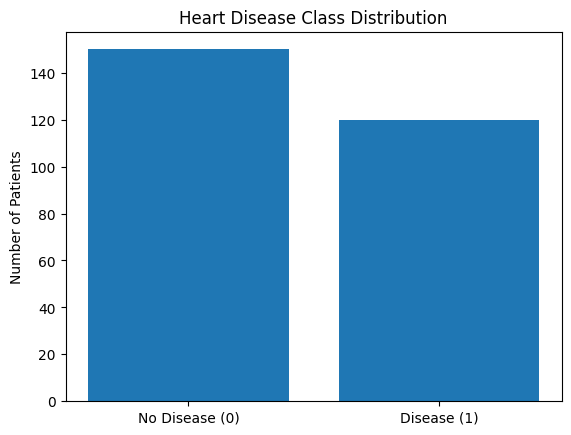

Disease rate: 0.4444444444444444


In [14]:
import matplotlib.pyplot as plt

counts = df[TARGET_COL].value_counts().sort_index()

plt.figure()
plt.bar(["No Disease (0)", "Disease (1)"], counts.values)
plt.title("Heart Disease Class Distribution")
plt.ylabel("Number of Patients")
plt.show()

print("Disease rate:", df[TARGET_COL].mean())


In [16]:

def stratified_split(df, target_col, test_size=0.30, seed=42):
    rng = np.random.default_rng(seed)

    df0 = df[df[target_col] == 0]
    df1 = df[df[target_col] == 1]

    n0_test = int(round(len(df0) * test_size))
    n1_test = int(round(len(df1) * test_size))

    idx0 = rng.permutation(df0.index)
    idx1 = rng.permutation(df1.index)

    test_idx = np.concatenate([idx0[:n0_test], idx1[:n1_test]])
    train_idx = np.concatenate([idx0[n0_test:], idx1[n1_test:]])

    train_df = df.loc[train_idx].sample(frac=1, random_state=seed)  
    test_df  = df.loc[test_idx].sample(frac=1, random_state=seed)
    return train_df, test_df



train_df, test_df = stratified_split(df, TARGET_COL)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

print("Train disease rate:", train_df[TARGET_COL].mean())
print("Test disease rate :", test_df[TARGET_COL].mean())


Train shape: (189, 14)
Test shape : (81, 14)
Train disease rate: 0.4444444444444444
Test disease rate : 0.4444444444444444
